# Power Analysis

In [1]:
%matplotlib inline
import os
import computeDEL
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
import wrapFunctions #import wrap180, wrap360, wrapList
import glob
import pandas as pd
from ggplot import *
import seaborn as sns
from scipy import stats

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Parameters

In [2]:
dataFolder = 'data30'
dataFile  = os.path.join(dataFolder,'dataFile.csv')

figFolder = 'powerAnalysis'


lowTurb = True # Limit by TI?
tiLim = 6. # % TI to limit to 

In [3]:
# Load data
df = pd.read_csv(dataFile)

In [31]:
df.LabVIEWTimestamp_mean.head()

0    3.553107e+09
1    3.553107e+09
2    3.553115e+09
3    3.553115e+09
4    3.553115e+09
Name: LabVIEWTimestamp_mean, dtype: float64

In [4]:

for c in df.columns:
    print c

OPC_In_RotorSpd_mean
BL1_FlapMom_mean
Azimuth_mean
TowerBaseTorque_mean
Yaw_Encoder_mean
TB_ForeAft_mean
WS1_90m_mean
LSSDW_Mz_mean
LSSDW_My_mean
TTTq_mean
TT_ForeAft_mean
Pitch_Blade1_mean
LSSDW_Tq_mean
TT_SideSide_mean
ApparentPower_mean
apparantVane_mean
WD_Nacelle_mean
BL1_EdgeMom_mean
Mainshaft_Downwind_Torque_mean
LidarOffset_mean
LabVIEWTimestamp_mean
Mainshaft_Downwind_Bend_90_mean
TowerTopTorque_mean
WD1_87m_mean
TBTq_mean
TB_SideSide_mean
OPC_In_RotorSpd_std
BL1_FlapMom_std
Azimuth_std
TowerBaseTorque_std
Yaw_Encoder_std
TB_ForeAft_std
WS1_90m_std
LSSDW_Mz_std
LSSDW_My_std
TTTq_std
TT_ForeAft_std
Pitch_Blade1_std
LSSDW_Tq_std
TT_SideSide_std
ApparentPower_std
apparantVane_std
WD_Nacelle_std
BL1_EdgeMom_std
Mainshaft_Downwind_Torque_std
LidarOffset_std
LabVIEWTimestamp_std
Mainshaft_Downwind_Bend_90_std
TowerTopTorque_std
WD1_87m_std
TBTq_std
TB_SideSide_std
OPC_In_RotorSpd_min
BL1_FlapMom_min
Azimuth_min
TowerBaseTorque_min
Yaw_Encoder_min
TB_ForeAft_min
WS1_90m_min
LSSDW_Mz_

In [18]:
# Limit to the yaw cone of interest
dfSub = df[['WS1_90m_mean','ApparentPower_mean','LidarOffset_mean','apparantVane_mean','WD_Nacelle_mean','WS1_90m_std']]

In [19]:
# Get rid of high error cases
dfSub['controlError'] = abs(dfSub.LidarOffset_mean + (dfSub.WD_Nacelle_mean - 180.))
#dfSub.controlError.hist()
dfSub = dfSub[dfSub.controlError<6.]

C:\Python27\lib\site-packages\ipython-3.2.0-py2.7.egg\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [20]:
# Continue to limit channels
dfSub['nacelleOffset'] = -1. * dfSub.LidarOffset_mean
dfSub = dfSub[['nacelleOffset','WS1_90m_mean','ApparentPower_mean','WS1_90m_std','WD_Nacelle_mean']]
dfSub.WD_Nacelle_mean = dfSub.WD_Nacelle_mean - 180.

In [21]:
# Cut the offsets into bins
dfSub['offset'] = pd.cut(dfSub.nacelleOffset.astype('int'),[-27,-23,-2,2,11,14,23,27],labels=[-25,-99,0,-98,12.5,-97,25])
dfSub = dfSub[dfSub.offset.isin([-25,0,12.5,25])]#.astype(int)
dfSub['offset'] = dfSub.offset.astype(float)
dfSub.offset.unique()

array([  0. ,  25. ,  12.5, -25. ])

In [22]:
dfSub.to_csv('powerData.csv')

In [23]:
# Sort dfSub by nacBins
dfSub = dfSub.sort_values(by='offset')

In [24]:
# cut the wind speed into bins
binEdge = np.arange(2.5,16.5)
binLabels = np.arange(3,16)
dfSub['windRange'] = pd.cut(dfSub.WS1_90m_mean,binEdge,right=True,labels=binLabels)

In [25]:
# Collect statistics
dfGrouped = pd.groupby(dfSub,['offset','windRange']).agg(['mean','std','count'])

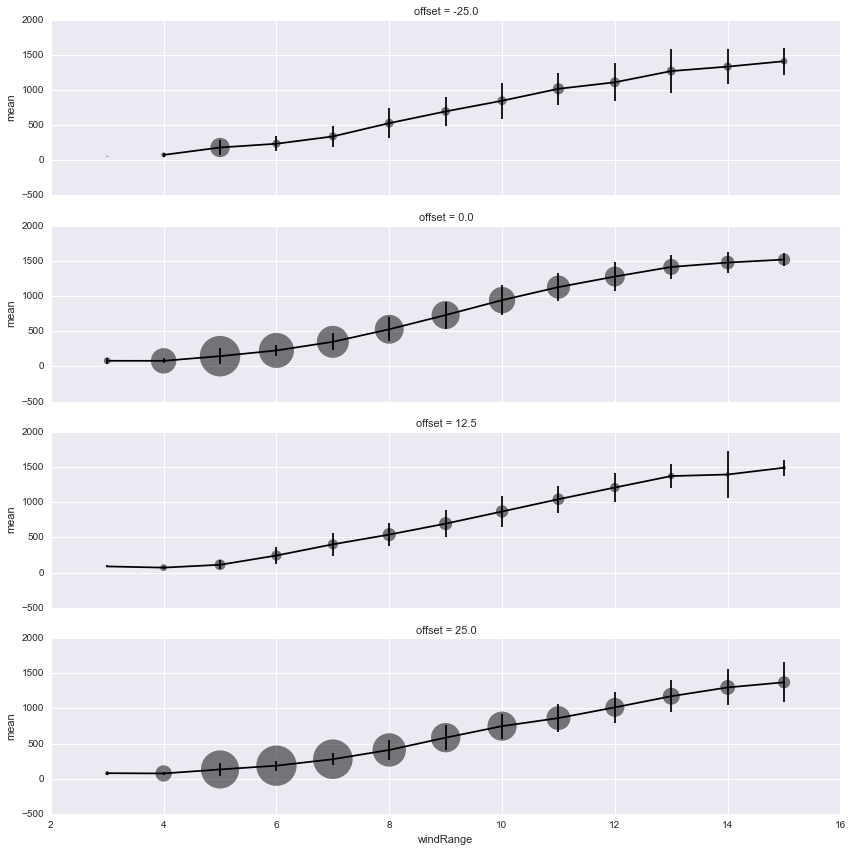

In [26]:
# Plot the powers

dfStats = dfGrouped['ApparentPower_mean'].reset_index()


g = sns.FacetGrid(dfStats, row="offset", aspect=4)#, ylim=(0, 10))
g.map(plt.errorbar, "windRange", "mean", "std", capsize=4,c='k')
g.map(plt.scatter, "windRange", "mean", 'count', color='k',alpha=0.5)

#for ax in g.axes.flat:
#    ax.axvline(-25,color='r')
#    ax.axvline(0,color='r')
#    ax.axvline(25,color='r')
#    ax.grid()
#    ax.legend()
#g.savefig(os.path.join(figFolder,'power.png'),dpi=150)

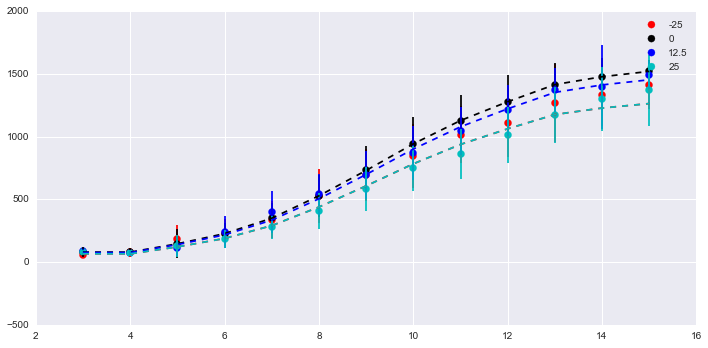

In [27]:
cosPow = 1.88

dfStats = dfGrouped['ApparentPower_mean'].reset_index()
base = dfStats[dfStats.offset == 0]['mean']


# Plot in a more controlled way
fig, ax = plt.subplots(1,1,figsize=(10,5))
#for i, (offset, c, j) in enumerate(zip([-25,0,12.5,25],['r','k','b','c'],[-.2,-.1,0,.1])):
for i, (offset, c, j) in enumerate(zip([-25,0,12.5,25],['r','k','b','c'],[0.,0.,0.,0.])):
    #print j
    dfOff = dfStats[dfStats.offset == offset]
    
    # First plot the data
    #ax.errorbar(dfOff.windRange,dfOff.mean,dfOff.std)
    #ax.errorbar(dfOff['windRange'],dfOff['mean'],dfOff['std']/np.sqrt(dfOff['count']),ls='None',color=c)
    ax.errorbar(dfOff['windRange'].astype(float)+j,dfOff['mean'],dfOff['std'],ls='None',color=c)
    ax.scatter(dfOff['windRange'].astype(float)+j,dfOff['mean'],color=c,s=50,label=offset)
    
    #x=windSpeeds
    #x = np.arange(3,16,100)
    y= np.array(base) * np.cos(offset * np.pi/180.)**cosPow
    #print y
    ax.plot(dfOff['windRange'].astype(float),y,'--',color=c)
    
ax.legend()

fig.savefig(os.path.join(figFolder,'combinedPow.png'),dpi=150)

#g.map(plt.errorbar, "windRange", "mean", "std", capsize=4,c='k')
#g.map(plt.scatter, "windRange", "mean", 'count', color='k',alpha=0.5)

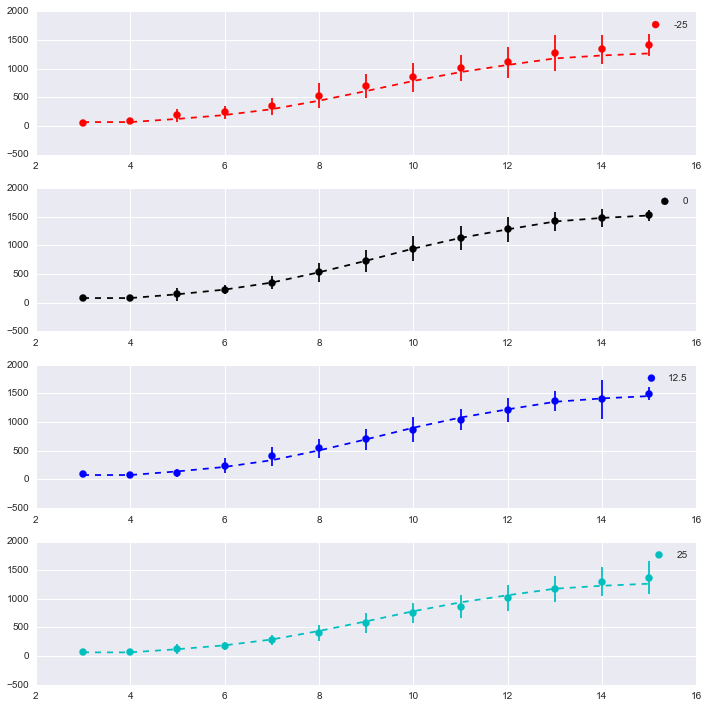

In [28]:
cosPow = 1.88

dfStats = dfGrouped['ApparentPower_mean'].reset_index()
base = dfStats[dfStats.offset == 0]['mean']


# Plot in a more controlled way
fig, axarr = plt.subplots(4,1,figsize=(10,10))
for i, (offset, c, j) in enumerate(zip([-25,0,12.5,25],['r','k','b','c'],[-.2,-.1,0,.1])):
    ax = axarr[i]
    dfOff = dfStats[dfStats.offset == offset]
    
    # First plot the data
    #ax.errorbar(dfOff.windRange,dfOff.mean,dfOff.std)
    #ax.errorbar(dfOff['windRange'],dfOff['mean'],dfOff['std']/np.sqrt(dfOff['count']),ls='None',color=c)
    ax.errorbar(dfOff['windRange'].astype(float),dfOff['mean'],dfOff['std'],ls='None',color=c)
    ax.scatter(dfOff['windRange'].astype(float),dfOff['mean'],color=c,s=50,label=offset)
    
    #x=windSpeeds
    #x = np.arange(3,16,100)
    y= np.array(base) * np.cos(offset * np.pi/180.)**cosPow
    #print y
    ax.plot(dfOff['windRange'].astype(float),y,'--',color=c)
    
    ax.legend()

fig.savefig(os.path.join(figFolder,'splitPow.png'),dpi=150)
#g.map(plt.errorbar, "windRange", "mean", "std", capsize=4,c='k')
#g.map(plt.scatter, "windRange", "mean", 'count', color='k',alpha=0.5)

In [30]:
# Save the data we have
dfSub.head()
dfSub.to_csv('powerAnalysis/data.csv',index=False)